# CIFAR Classification Task with simple CNN and pretrained model with PyTorch

---

How to Use This Notebook
---

**Recommended Setup**
- For the best experience, **run this notebook on [Google Colab](https://colab.research.google.com/)**—especially if your local machine is slow.  
- In Colab, **enable GPU support** by going to:  
  `Runtime > Change runtime type > Hardware accelerator > GPU`

---





### Larger and more complex image dataset


This notebook will explore **Convolutional Neural Networks (CNNs)** and **pretrained model** to apply Transfer Learning using **PyTorch**. This project is the continuation of [previous project on FashionMNIST](https://github.com/ignsagita/neuralnets-fashionmnist). In Fashion MNIST classification, the subject is always in the center of a 28x28 image. This means the network only needs to get important features from a fixed area.

However, in this section, we  will use the [**CIFAR-10**](https://www.cs.toronto.edu/~kriz/cifar.html) dataset which contains 60,000 32x32 color images (RGB) in 10 classes, with 6,000 images per class. We will train a Convolutional Neural Network to recognize features in an image where the subject can be anywhere, and the network is trained to recognize features that determine which is which.

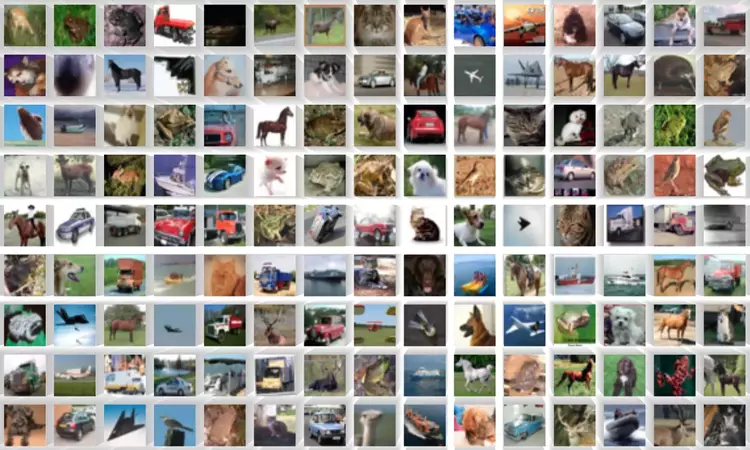

Here are the classes in the dataset, as well as 10 random images from each: <br>
- airplane <br>
- automobile <br>
- bird <br>
- cat <br>
- deer <br>
- dog <br>
- frog <br>
- horse <br>
- ship <br>
- truck <br>

## OUTLINE:
- Automatic data handling from Github repository
- Train/Validation/Test split with stratification
- Custom MLP and CNN architectures
- Early stopping with best model saving
- Integrated training pipeline for both models
- Visualize the result
- Kernels and Feature map visualization for CNN layers

## Preprocessing

Includes:
- Normalize the images to have zero mean and unit variance
- Use PyTorch's built-in dataset and dataloader utilities
- Load both training and test sets

#### Library install

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score, accuracy_score

#### Load and Transform the CIFAR-10 Dataset

##### Normalization
Here, we apply transformations to resize images, convert them to tensors, and normalize. Then we load the CIFAR-10 dataset and preparing DataLoader for batch processing.

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize RGB channels
])


In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Download the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Download the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


In [4]:
# Class names for CIFAR-10 labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [6]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

##### Train and test split

In [7]:
# Split the training dataset into training and validation sets (e.g., 80% train, 20% val)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

##### Creating dataloader

In [8]:
# Create DataLoaders for training, validation and test subsets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

#### Visualize Some Images

Before training our CNN, it's helpful to **visualize the data** we're working with.
We'll define a helper function to show a few sample images along with their corresponding labels.

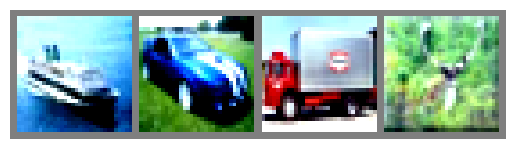

ship The class lables are:car The class lables are:truck The class lables are:deer


In [9]:
# Helper function to unnormalize and show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from CHW to HWC for plotting
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the first 4 images from the batch
imshow(torchvision.utils.make_grid(images[:4]))
# Print the corresponding class labels
print(' The class lables are:'.join(f'{classes[labels[j]]}' for j in range(4)))

## Modelling

### a Simple Convolutional Neural Network

We define our CNN model using `nn.Module`. It consists of:
- One convolutional layer followed by ReLU and max pooling
- Two fully connected layers

This simple architecture is good for learning and experimentation.

** How Convolutional Neural Networks Work? **


Convolutional neural networks (CNNs) are commonly used for image classification tasks. At a high level, CNNs contain three main types of layers:

- Convolutional layers: Apply convolutional filters to the input to extract features. The neurons in these layers are called filters and capture spatial patterns in the input.
- Pooling layers: Downsample the feature maps from the convolutional layers to consolidate information. Max pooling and average pooling are commonly used strategies.
- Fully-connected layers: Take the high-level features from the convolutional and pooling layers as input for classification. Multiple fully-connected layers can be stacked.

The convolutional filters act as feature detectors, learning to activate when they see specific types of patterns or shapes in the input image. As these filters are applied across the image, they produce feature maps that highlight where certain features are present.

![CNN Building GIF](https://www.kdnuggets.com/wp-content/uploads/awan_building_convolutional_neural_network_pytorch_1.gif)


Padding involves adding extra pixels around the input image’s border.
Padding ensures that the filter fits properly over the image, especially at the edges. Without padding, the feature map’s size reduces after each convolution operation

 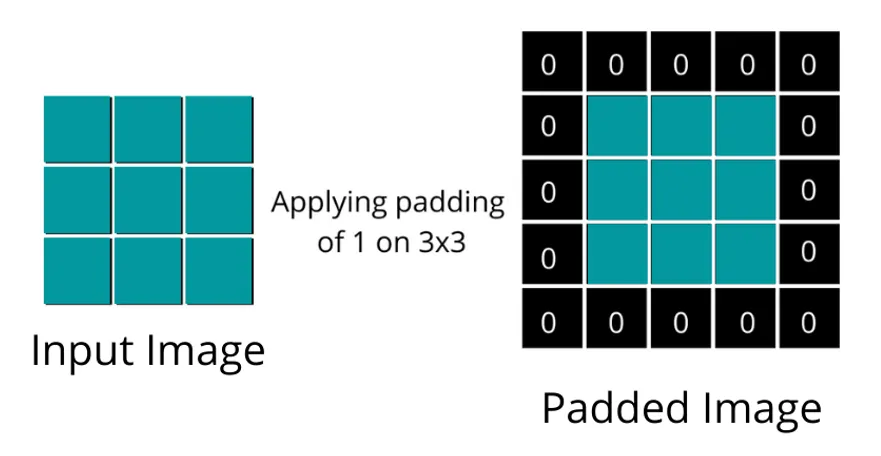

Max pooling takes the maximum value from each patch of the feature map.
Average pooling takes the average value from each patch of the feature map.

This operation reduces the size of the feature map by half, both horizontally and vertically, but retains the most prominent features.

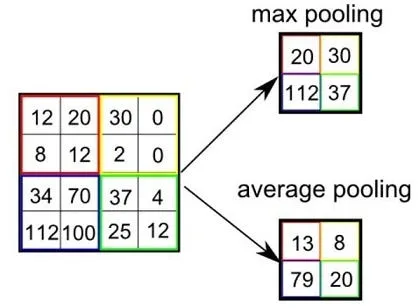

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Max pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> Pool
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> Pool
        x = self.dropout(x)  # Apply dropout after conv blocks
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout in FC layer
        x = self.fc2(x)
        return x

 Model Summary with `torchsummary`

To get a layer-by-layer breakdown of your custom PyTorch model, you can use the `torchsummary` package. This is especially useful to understand the number of parameters, shapes, and types of layers used.

In [11]:
net = SimpleCNN()
summary(net, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
           Dropout-7             [-1, 64, 8, 8]               0
            Linear-8                  [-1, 512]       2,097,664
           Dropout-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
Total params: 2,122,378
Trainable params: 2,122,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.88
Params size (MB): 8.10
Estimat

## Using a pretrained model like ResNet18

In this section, we explore a pretrained **ResNet18** model from `torchvision.models`.


Instead of training a CNN from scratch, we can reuse the **feature extraction layers** of a model trained on a large dataset (like ImageNet), and only retrain the final layer(s) for our own task.

**Benefits:**
- Much faster training
- Requires less data
- Often achieves higher accuracy

We use **[ResNet18](https://pytorch.org/hub/pytorch_vision_resnet/)**, a deep residual network, pretrained on ImageNet.

---

In [12]:
# Import ResNet18 from torchvision
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet18
pre = models.resnet18(pretrained=True)

# Freeze all layers except the final layer
for param in pre.parameters():
    param.requires_grad = False

# Modify the final fully connected layer of ResNet-18 to match CIFAR-10
#In the case of ResNet18, the last layer is nn.Linear(512, 1000)

num_ftrs = pre.fc.in_features

# The new linear layer has num_ftrs input features and 10 output features (for 10 classes)
pre.fc = nn.Linear(num_ftrs, 10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


In [13]:
# Model summary
summary(pre, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Baseline: CustomCNN

Implement a CustomCNN class that builds a convolutional neural network with the following layers:
- Conv2d(3, 32, kernel_size=3, padding=1), ReLU, MaxPool2d(2,2)
- Conv2d(32, 64, kernel_size=3, padding=1), ReLU, MaxPool2d(2,2)
- Flatten
- Linear(64×8×8, 128), ReLU, Dropout(0.3)
- Linear layer taking 128 inputs with 10 outputs

Note: torch.nn is already imported as nn, and you may use functional components from F.

In [14]:
class CustomCNN(nn.Module):
    def __init__(self):
        # continue
        super(CustomCNN, self).__init__()
        #first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        #second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        #define relu function above
        self.relu = nn.ReLU()

        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.dropout_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # continue
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> BN -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> BN -> ReLU -> Pool
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout in FC layer
        x = self.fc2(x)
        return x


In [15]:
cust = CustomCNN()
summary(cust, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                  [-1, 128]         524,416
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 545,098
Trainable params: 545,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.85
Params size (MB): 2.08
Estimated T

### Integrate the training pipeline for all models

Now that we’ve defined our models, we:
- Instantiate the model
- Choose a **loss function** suitable for multi-class classification: `CrossEntropyLoss`
- Use **Stochastic Gradient Descent (SGD)** as our optimizer

In PyTorch one needs to define which device to use for computation. All tensors involved in the computation need to be on that device. The most common devices are: <br>
- cpu: any of your computer's CPUs
- cpu:0:the first of your computer's CPUs
- cuda: any of your computer's GPUs
- cuda:2: the third GPU of you computer

In [16]:
# get gpu if available else cpu:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, path="best_model.pt"):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.best_state_dict = None
        self.path = path

    def check_early_stop(self, loss_valid, model):
        if self.best_loss is None or loss_valid < self.best_loss - self.delta:
            self.best_loss = loss_valid
            self.no_improvement_count = 0
            # Save a copy of the model's parameters.
            self.best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            torch.save(model.state_dict(), self.path)
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True

In [18]:
def epoch(model, trainloader, optimizer, loss_fn):
  # 1. set model to train:
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += (logits.argmax(dim=1) == y).sum().item()

    return running_loss / max(1, len(trainloader)), running_acc / max(1, len(trainloader))

@torch.no_grad()
def evaluate(model, loader, loss_fn, device=device):
    model.eval()
    running_acc = 0.0
    losses = []
    all_pred, all_true = [], []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        if loss_fn is not None:
            losses.append(loss_fn(logits, y).item())
        pred = logits.argmax(dim=1)
        all_pred.append(pred.cpu())
        all_true.append(y.cpu())
        running_acc += (logits.argmax(dim=1) == y).sum().item()
    y_pred = torch.cat(all_pred).numpy()
    y_true = torch.cat(all_true).numpy()
    metrics = {
        "acc": accuracy_score(y_true, y_pred),
        "f1":  f1_score(y_true, y_pred, average="macro"),
    }
    if loss_fn is not None:
        metrics["loss"] = float(np.mean(losses)) if len(losses) else float("nan")
    return metrics

def fit(model: nn.Module,
        trainloader: DataLoader,
        validloader: DataLoader,
        *,
        epochs: int = 20,
        lr: float = 1e-3,
        patience: int = 5,
        momentum: float = 0.9,
        device=device,
        model_name: str = "model") -> pd.DataFrame:
    model = model.to(device)
    loss_fn   = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Same scheduler for both models (fairness)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.33, total_iters=10)
    es = EarlyStopping(patience=patience, path=f"{model_name}_best.pt")

    history = []
    for ep in range(1, epochs+1):
        train_loss, train_acc = epoch(model, trainloader, optimizer, loss_fn)
        val_metrics = evaluate(model, validloader, loss_fn, device)
        scheduler.step()

        history.append({
            "epoch": ep,
            "loss_train": train_loss,
            "loss_valid": val_metrics["loss"],
            "acc_valid":  val_metrics["acc"],
            "f1_valid":   val_metrics["f1"],
            "lr": optimizer.param_groups[0]["lr"],
        })

        es.check_early_stop(val_metrics["loss"], model)
        if es.stop_training:
            break

    # Load the best weights before returning
    model.load_state_dict(torch.load(f"{model_name}_best.pt", map_location=device))
    return pd.DataFrame(history), model

#### Instantiate the model

We'll train the model over 2 epochs.
In each epoch, we:
- Loop over the training dataset in batches
- Perform a forward pass
- Compute the loss
- Backpropagate the error
- Update the model parameters

We print the loss every 200 mini-batches to track learning progress.

After each training epoch, we also evaluate the model on a separate **validation set**.
This helps monitor the model's generalization and detect overfitting early.

In [19]:
COMMON = dict(epochs=20, lr=1e-3, patience=5)  # identical for all models

# Simple CNN
net = SimpleCNN()
early_stopping = EarlyStopping(patience=5)
net_hist, net_best = fit(net, trainloader, valloader, model_name="simple", **COMMON)
net_val = net_hist.iloc[-1]  # last logged epoch (note: weights are best)
net_test = evaluate(net_best, testloader, loss_fn=nn.CrossEntropyLoss(), device=device)

# Resnet-18 - Pretrained model
pre = models.resnet18(pretrained=True)
# Freeze all layers except the final layer
for param in pre.parameters():
    param.requires_grad = False
# Modify the final fully connected layer of ResNet-18 to match CIFAR-10
#In the case of ResNet18, the last layer is nn.Linear(512, 1000)
num_ftrs = pre.fc.in_features
# The new linear layer has num_ftrs input features and 10 output features (for 10 classes)
pre.fc = nn.Linear(num_ftrs, 10)
pre_hist, pre_best = fit(pre, trainloader, valloader, model_name="resnet-18", **COMMON)
pre_val = pre_hist.iloc[-1]
pre_test = evaluate(pre_best, testloader, loss_fn=nn.CrossEntropyLoss(), device=device)

# Custom CNN
cust = CustomCNN()
early_stopping = EarlyStopping(patience=5)
cust_hist, cust_best = fit(cust, trainloader, valloader, model_name="custom", **COMMON)
cust_val = cust_hist.iloc[-1]  # last logged epoch (note: weights are best)
cust_test = evaluate(cust_best, testloader, loss_fn=nn.CrossEntropyLoss(), device=device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
summary = pd.DataFrame([
    {"model": "SimpleCNN",
     "best_val_loss": net_val["loss_valid"], "best_val_acc": net_val["acc_valid"], "best_val_f1": net_val["f1_valid"],
     "test_loss": net_test["loss"] if "loss" in net_test else float("nan"),  # evaluate() returns loss when loss_fn provided
     "test_acc":  net_test["acc"], "test_f1": net_test["f1"]},
    {"model": "Resnet-18",
     "best_val_loss": pre_val["loss_valid"], "best_val_acc": pre_val["acc_valid"], "best_val_f1": pre_val["f1_valid"],
     "test_loss": pre_test["loss"], "test_acc": pre_test["acc"], "test_f1": pre_test["f1"]},
    {"model": "CustomCNN",
     "best_val_loss": cust_val["loss_valid"], "best_val_acc": cust_val["acc_valid"], "best_val_f1": cust_val["f1_valid"],
     "test_loss": cust_test["loss"], "test_acc": cust_test["acc"], "test_f1": cust_test["f1"]},
])
summary

,model,best_val_loss,best_val_acc,best_val_f1,test_loss,test_acc,test_f1
0,SimpleCNN,1.034394,0.6363,0.632308,1.045021,0.6320,0.628868
1,Resnet-18,1.556845,0.4742,0.470720,1.583386,0.4583,0.455407
2,CustomCNN,1.402597,0.5012,0.498017,1.393166,0.5026,0.499033


#### Visualization

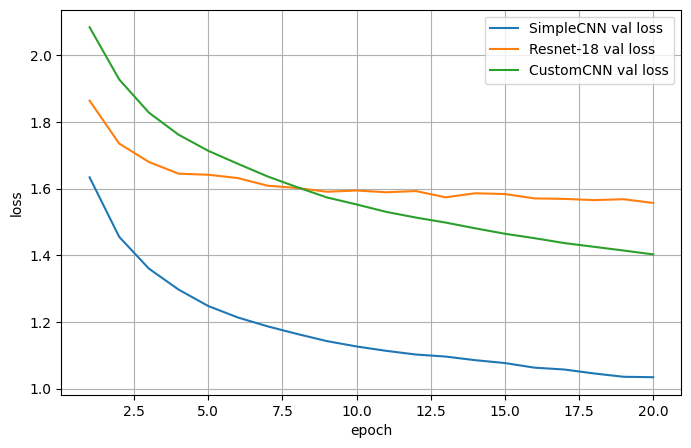

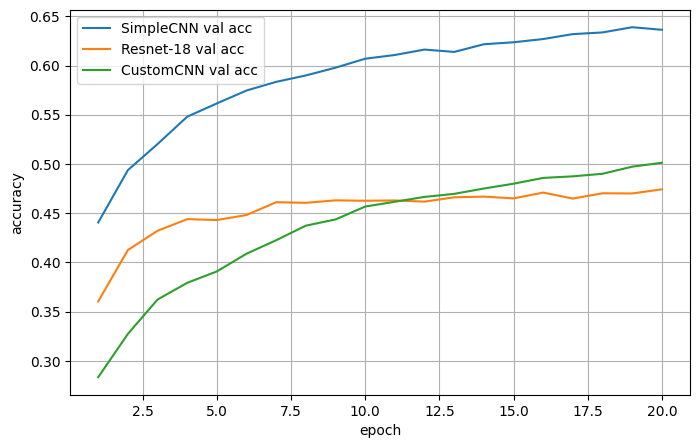

In [21]:
plt.figure(figsize=(8,5))
plt.plot(net_hist["epoch"], net_hist["loss_valid"], label="SimpleCNN val loss")
plt.plot(pre_hist["epoch"], pre_hist["loss_valid"], label="Resnet-18 val loss")
plt.plot(cust_hist["epoch"], cust_hist["loss_valid"], label="CustomCNN val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(net_hist["epoch"], net_hist["acc_valid"], label="SimpleCNN val acc")
plt.plot(pre_hist["epoch"], pre_hist["acc_valid"], label="Resnet-18 val acc")
plt.plot(cust_hist["epoch"], cust_hist["acc_valid"], label="CustomCNN val acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.grid(True); plt.show()